# Metadata annotation

Publically availble metadata can help contexualize an in-house experiment. Pertpy allows metadata to be easily fetched and perturbations to be annotated, augmenting existing datasets to increase sample sizes for training of machine learning models and add prior knowledge.

A couple of databases can be queried, which we categorize by the type of metadata:
- Cell line metadata： 
    - Cancer Dependency Map (DepMap) at Broad
    - Genomics of Drug Sensitivity in Cancer (GDSC)
- Genomic datasets:
    - DepMap at Broad: Gene expression data
    - DepMap at Sanger: Gene expression and protein intensity values
- Cell line x perturbation interactions:
    - Genomics of Drug Sensitivity in Cancer (GDSC): Drug sensitivity

This notebook demonstrates how you can use pertpy metadata with two examples:

1. Sanity check of private data with publically available cell line expression profiles
2. Analysis of cell-line specific IC50-related genes using the GDSC database

In [1]:
import random
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

Let's use the dataset from the original MIX-Seq paper ([McFarland et al., 2020](https://www.nature.com/articles/s41467-020-17440-w)), a scRNA-seq dataset of 99 cell lines and 13 different drugs. We subset it to 50000 cells to speed up the run time.

In [2]:
adata = pt.dt.mcfarland_2020()

In [3]:
adata

AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [4]:
sc.pp.filter_genes(adata, min_cells=30)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.subsample(adata, n_obs=50000, random_state=42)

## Cell line metadata

`annotate` uses a column in `.obs` called `DepMap_ID` as identifiers and adds metadata columns to `.obs`. We only annotate using 3 metadata columns here, but you can see the full set of available metadata using `lookup.cell_line_meta`.

Data is downloaded to the directory for cache files used by scanpy (Defaults to `cache`).

In [5]:
cl_metadata = pt.md.CellLine()
cl_metadata.annotate(adata, query_id='DepMap_ID', cell_line_information=["cell_line_name", "age", "primary_disease"])

In [8]:
adata

AnnData object with n_obs × n_vars = 50000 × 25031
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line_name', 'age', 'primary_disease'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    uns: 'log1p'

Annotated metadata is saved as additional columns in `adata.obs`.

In [7]:
adata.obs.iloc[:, 36:]

,cell_line_name,age,primary_disease
TTATGCTAGTGATCGG,NCI-H1581,44,Lung Cancer
AGCGTCGTCTCGGACG,SNU-1105,61,Brain Cancer
TTGGGTACATTGCTTT,SK-MEL-3,42,Skin Cancer
TACTTGTTCAGCGACC,786-O,58,Kidney Cancer
CACAGTATCGGCTACG,COLO-680N,57,Esophageal Cancer
...,...,...,...
TGCCCTACATGAGCGA,KYSE-270,79,Esophageal Cancer
CTGATCCGTATGTCAC,BT-474,60,Breast Cancer
TATTACCAGCAGACTG,NCI-H460,NaN,Lung Cancer
TGTGGTATCTCCAGGG,SK-MEL-3,42,Skin Cancer


We can check the number of overlapping cell lines using `lookup`.

In [10]:
lookup = cl_metadata.lookup()
lookup.available_cell_lines(query_id_list=adata.obs.cell_line.unique(), reference_id="cell_line_name")

171 cell lines are not found in the metadata.

38 cell lines are found!

Hmmm, it looks like there isn't much overlap with existing databases using the cell line names. However, there is complete overlap when mapping using DepMap_ID! This is due a slight inconsistency in using dashes in cell line names, so try to use a unique ID as much as possible.

In [11]:
lookup.available_cell_lines(query_id_list=adata.obs.DepMap_ID.unique(), reference_id="DepMap_ID")

0 cell lines are not found in the metadata.

209 cell lines are found!

One question we might have after sequencing an in vitro experiment is "How similar are our expression profiles compared to the public database?" To answer this, we generate "pseudobulks" by aggregating counts to the cell-type level and then compare them with bulk RNA-seq data.

In [14]:
ps = pt.tl.PseudobulkSpace()
# Calculate the pseudobulks
pdata = ps.compute(adata, target_col="cell_line_name", groups_col="perturbation")
# Extract the base line expression
base_line = pdata[pdata.obs.perturbation == 'control']
base_line.obs.index = base_line.obs.index.str.replace('_control', '')

/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/decoupler/utils_anndata.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cols = obs.groupby([sample_col, groups_col]).apply(lambda x: x.apply(lambda y: len(y.unique()) == 1)).all(0)
/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [15]:
lookup.available_bulk_rna(query_id_list=adata.obs.DepMap_ID.unique(), cell_line_source='broad')

25 cell lines are not found in the metadata.

184 cell lines are found!

We annotate bulk RNA expression data from the Broad Institute because it contains more overlapping cell lines with the McFarland dataset.

In [18]:
cl_metadata.annotate_bulk_rna(base_line, cell_line_source="broad", query_id="DepMap_ID")

To annotate bulk RNA data from Broad Institue,  `DepMap_ID` is used as default reference and query identifier if no
`reference_id` is given.  Ensure that `DepMap_ID` is available in 'adata.obs'.  Alternatively, use `annotate()` to 
annotate the cell line first

[bold blue]There are 155 identifiers in `adata.obs`.However, 19 identifiers can't be found in the bulk RNA annotation,leading to the presence of NA values for their respective metadata.

- Please check again: 
- ACH-000886
- ACH-000666
- ACH-000015
- ACH-000579
- ACH-000900
- ...


/Users/yuge.ji/Desktop/marvin/pertpy/pertpy/metadata/_cell_line.py:398: ImplicitModificationWarning: Setting element `.obsm['bulk_rna_broad']` of view, initializing view as actual.
  adata.obsm["bulk_rna_broad"] = ccle_expression


AnnData object with n_obs × n_vars = 155 × 25031
    obs: 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'cell_line_name', 'age', 'primary_disease', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    obsm: 'bulk_rna_broad'
    layers: 'psbulk_props'

The bulk RNA expression data is stored in `adata.obsm[bulk_rna_broad]`

In [19]:
base_line.obsm['bulk_rna_broad']

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
22Rv1,2.179511,0.0,6.316146,3.407353,4.642702,0.014355,0.124328,5.816088,7.045814,5.057017,...,0.000000,0.000000,0.000000,0.028569,0.250962,0.432959,3.875780,0.137504,0.0,0.000000
253J-BV,3.942045,0.0,5.967169,1.883621,3.581351,0.000000,0.084064,5.087463,4.444932,3.794936,...,0.000000,0.201634,0.124328,0.000000,0.150560,0.526069,4.526069,0.214125,0.0,0.000000
42-MG-BA,3.880686,0.0,6.733083,1.922198,3.390943,0.028569,0.575312,5.816856,3.313246,3.903038,...,0.028569,0.000000,0.042644,0.014355,0.070389,0.555816,2.601697,0.000000,0.0,0.084064
5637,5.128871,0.0,6.691534,2.010780,4.976364,0.163499,1.636915,6.193575,3.505891,3.709291,...,0.000000,0.000000,0.150560,0.028569,0.014355,0.298658,2.978196,0.000000,0.0,0.000000
639-V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEN,4.418190,0.0,7.247453,2.134221,3.841973,0.000000,0.070389,6.435795,3.740928,4.249445,...,0.000000,0.000000,0.084064,0.014355,0.226509,0.389567,4.275752,0.070389,0.0,0.000000
TUHR4TKB,4.309613,0.0,7.265849,2.042644,3.553361,0.097611,5.257765,6.048105,4.058316,3.539779,...,0.000000,0.000000,0.000000,0.000000,0.014355,0.411426,4.647315,0.000000,0.0,0.000000
UACC-257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UM-UC-1,5.683416,0.0,7.125155,1.963474,2.523562,0.028569,2.969012,5.472488,4.869378,3.543496,...,0.000000,0.000000,0.000000,0.189034,0.000000,0.731183,2.587365,0.000000,0.0,0.000000


In [20]:
# Subset and sort overlapping genes
overlapping_genes = set(base_line.var.ensembl_id) & set(base_line.obsm['bulk_rna_broad'].columns)
base_line = base_line[:, base_line.var['ensembl_id'].isin(overlapping_genes)]
base_line.obsm['bulk_rna_broad'] = base_line.obsm['bulk_rna_broad'][base_line.var.ensembl_id]

/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_47969/4254373752.py:4: ImplicitModificationWarning: Setting element `.obsm['bulk_rna_broad']` of view, initializing view as actual.
  base_line.obsm['bulk_rna_broad'] = base_line.obsm['bulk_rna_broad'][base_line.var.ensembl_id]


In [21]:
# Correlate the pseudobulks with the bulk RNA-seq data
# corr and pvals: correlation and p-value df for the overlapping cell lines
# new_corr and new_pvals: correlation and p-value df for cell lines that are only present in McFarland dataset
corr, pvals, new_corr, new_pvals = cl_metadata.correlate(base_line, identifier="DepMap_ID", metadata_key = "bulk_rna_broad")

Column name of metadata is not the same as the index of adata.var. Ensure that the genes are in the same order.

In [22]:
# Visualize the correlation of cell lines by scatter plot
cl_metadata.plot_correlation(base_line, corr = corr, pval = pvals, 
                          identifier="DepMap_ID", metadata_key = "bulk_rna_broad",
                          subset_identifier = 0) # 0 means the first ids

KeyError: "None of [Index(['ACH-000956'], dtype='object')] are in the [index]"

We observe a high correlation between the baseline gene expression in the McFarland dataset and the bulk RNA-seq expression data from the Broad Institute, suggesting good concordance between these two sources. We can also visualize the correlation matrix via heatmap.

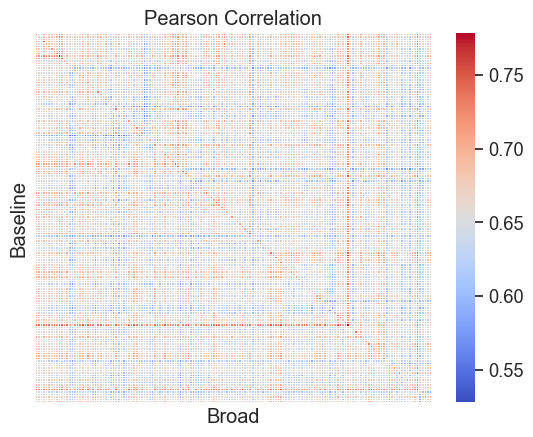

In [18]:
# Generally a cell line is most correlated with itself
sns.set(font_scale=1.2)
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=.7, xticklabels=False, yticklabels=False)
plt.title('Pearson Correlation')
plt.xlabel('Broad')
plt.ylabel('Baseline')
plt.show()

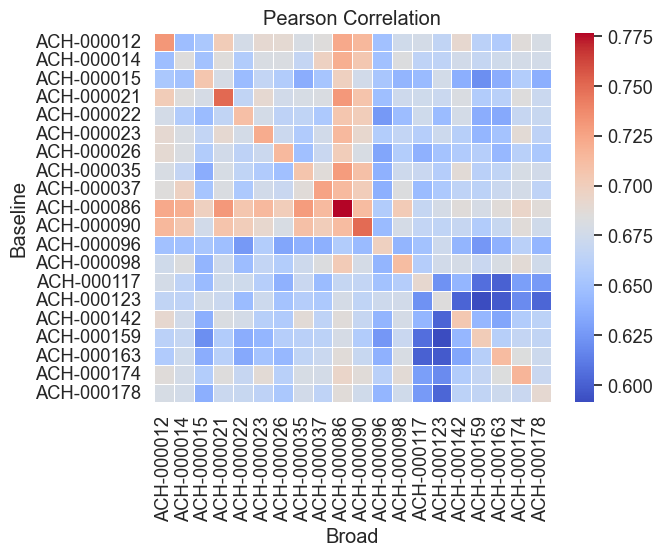

In [19]:
# Subset to first 20 cell lines
sns.heatmap(corr.iloc[:20,:20], cmap='coolwarm', annot=False, linewidths=.7, yticklabels=True)
plt.title('Pearson Correlation')
plt.xlabel('Broad')
plt.ylabel('Baseline')
plt.show()

The cell line that is not found in the broad database matches with the closest tissue type. TODO: Even I have no idea what you did here, even though it looks like it makes a lot of sense. Can you break it down clearly and simply? Why is there a pd_concat? Take a little longer to think of a more informative variable name than `new_corr`

In [26]:
new_cl_max_corr = pd.concat([new_corr.idxmax(axis=1), new_corr.max(axis=1)], axis=1, keys=['cell_line', 'correlation'])
new_cl_max_corr

,cell_line,correlation
DepMap_ID,,
ACH-000973,ACH-000842,0.743643
ACH-000288,ACH-000086,0.714262
ACH-000047,ACH-000842,0.735735
ACH-000595,ACH-000842,0.743950
ACH-000977,ACH-000905,0.703778
ACH-000750,ACH-000842,0.722284
ACH-000471,ACH-000976,0.720293
ACH-000510,ACH-000842,0.740806
ACH-000666,ACH-000086,0.702198


In [27]:
base_line[base_line.obs['DepMap_ID'].isin(["ACH-000047", "ACH-000842"])].obs['singlet_ID']

GCIY               GCIY_STOMACH
SW 480    SW480_LARGE_INTESTINE
Name: singlet_ID, dtype: object

## IC50-related genes using the GDSC database

Post-treatment differential expression data can offer valuable insights into understanding the relationship between gene expression and drug responses. To demonstrate how pertpy can be used to model perturbation responses, a linear regression model can be trained to associate the single-cell transcriptional profiles measured in each cell line to their viability effects in the drug sensitivity data from GDSC. 

Cell line-specific drug sensitivity data can be retrieved from the GDSC database, which will be saved as a single column `ln_ic50` in `obs`.

In [23]:
cl_metadata.annotate_from_gdsc(pdata, query_id = "cell_line_name")

[bold blue]There are 193 identifiers in `adata.obs`.However, 87 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.

- Please check again: 
- SNU-C2A
- HCT 116
- KP4
- UO-31
- Malme-3M
- ...


AnnData object with n_obs × n_vars = 1109 × 25031
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'age', 'primary_disease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    layers: 'psbulk_props'

In [28]:
pdata[~pdata.obs.ln_ic50.isna()].obs[['cell_line_name', 'perturbation', 'ln_ic50']]

,cell_line_name,perturbation,ln_ic50
index,,,
639-V_Afatinib,639-V,Afatinib,0.830291
8505C_Afatinib,8505C,Afatinib,4.756863
A549_Afatinib,A549,Afatinib,0.825679
CAL-29_Afatinib,CAL-29,Afatinib,-0.580518
COLO-680N_Afatinib,COLO-680N,Afatinib,1.810471
...,...,...,...
SUIT-2_Trametinib,SUIT-2,Trametinib,-4.544078
SW48_Trametinib,SW48,Trametinib,-2.957706
TE-11_Trametinib,TE-11,Trametinib,0.017331


In [29]:
# Subtract mean of the control from the perturbation, grouped by cell lines.
pdata.layers['counts'] = pdata.X.copy()
ps.compute_control_diff(pdata, target_col="perturbation", group_col="DepMap_ID", layer_key="counts")

AnnData object with n_obs × n_vars = 1109 × 25031
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'age', 'primary_disease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    layers: 'psbulk_props', 'counts', 'control_diff'

In [30]:
# Remove the missing values
pdata = pdata[pdata.obs.perturbation != "control"]
pdata = pdata[~pdata.obs.ln_ic50.isna()]
pdata

View of AnnData object with n_obs × n_vars = 247 × 25031
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'age', 'primary_disease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    layers: 'psbulk_props', 'counts', 'control_diff'

In [31]:
X_train, X_test, y_train, y_test = train_test_split(pdata.layers['control_diff'], pdata.obs.ln_ic50, 
                                                    test_size=0.1, random_state=2)
lr = LinearRegression() 
lr.fit(X_train, y_train)
y_predict= lr.predict(X_test)

Mean squared error: 4.58
Coefficient of determination: 0.56


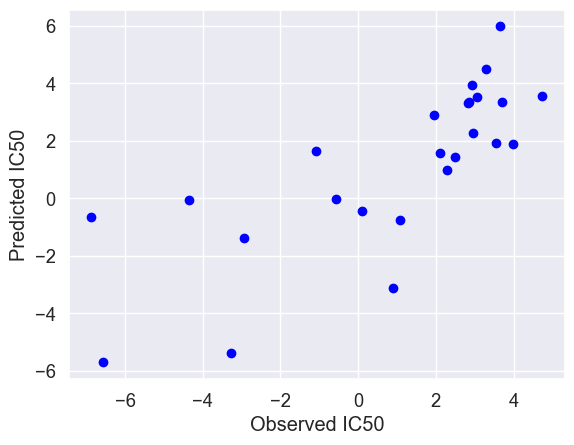

In [28]:
print(f"Mean squared error: {mean_squared_error(y_test, y_predict):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_predict):.2f}")
plt.scatter(y_test, y_predict, color="blue")
plt.xlabel("Observed IC50")
plt.ylabel("Predicted IC50")
plt.show()

The scatter plot shows the actual IC50 values along the x-axis and the IC50 values predicted by the linear regression model along the y-axis. Feature selection might improve the model performance since the dataset contains the 32738 genes.

We group the 99 McFarland cell lines with similar drug response across different perturbation conditions. TODO: Again, I'm not sure what's happening in the next line of code. A clear explanation would be great!

In [49]:
drug_response = cl_metadata.drug_response_gdsc1[cl_metadata.drug_response_gdsc1['cell_line_name'].isin(adata.obs.cell_line_name)].pivot(index='cell_line_name', columns='drug_name', values='ln_ic50')
drug_response

drug_name,(5Z)-7-Oxozeaenol,5-Fluorouracil,965-D2,993-D2,A-443654,A-770041,A-83-01,ACY-1215,AGI-6780,AICA Ribonucleotide,...,ZG-10,ZL049,ZL109,ZM447439,ZSTK474,Zibotentan,"eEF2K Inhibitor, A-484954",kb NB 142-70,rTRAIL,torin2
cell_line_name,,,,,,,,,,,,,,,,,,,,,
42-MG-BA,0.588826,2.220896,2.992956,4.755989,NaN,NaN,3.793761,2.390197,1.303087,7.562482,...,NaN,2.995327,-0.980930,1.339098,2.235509,5.494359,5.566457,3.082294,-1.651262,NaN
5637,1.626606,3.166983,4.410360,4.227483,NaN,NaN,3.847780,1.039981,1.127383,8.011505,...,NaN,2.053874,0.046212,0.556022,0.239659,5.144572,5.273391,2.519340,-2.889220,NaN
639-V,0.785227,4.210295,2.932099,4.028036,NaN,NaN,4.628202,2.099868,1.479390,7.448695,...,1.453090,4.385755,0.039382,1.779944,2.425340,5.144169,5.143294,1.978599,-2.467352,NaN
647-V,0.570678,3.228626,2.930507,3.106849,NaN,NaN,4.581358,1.754079,1.670076,7.547167,...,NaN,3.188942,-1.045608,3.044114,0.603523,5.756456,5.430844,2.733492,0.201503,NaN
769-P,0.612362,1.396611,3.010508,2.978909,NaN,NaN,3.855192,1.800764,1.943585,8.259149,...,NaN,3.162116,-0.425794,2.532378,-0.411142,5.441282,5.592060,1.830003,-0.026884,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TE-11,1.972644,4.283297,2.979829,3.598220,-2.093281,0.282573,4.005342,3.104331,1.730219,4.407174,...,NaN,3.992947,0.354113,0.406621,2.985028,5.396288,5.396288,3.860937,-0.753742,NaN
TE-6,5.312667,1.765484,5.250599,4.294427,-1.035718,2.397666,4.348313,0.522500,NaN,9.012906,...,NaN,3.040703,1.057910,3.795597,-0.236517,5.880011,5.693825,1.948988,0.353520,NaN
TE-8,-0.905723,2.297967,2.880687,3.359580,-1.749262,-1.274661,1.281641,0.520580,1.081485,6.899094,...,0.734422,2.860551,-0.444158,1.197542,1.441510,5.765258,5.138028,0.833960,0.221525,NaN


We'll fill in the missing values with 0 for now so that we can achieve a clustering:

In [36]:
adata_drug_reponse = ad.AnnData(drug_response.fillna(0))
adata_drug_reponse 

AnnData object with n_obs × n_vars = 116 × 378

/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


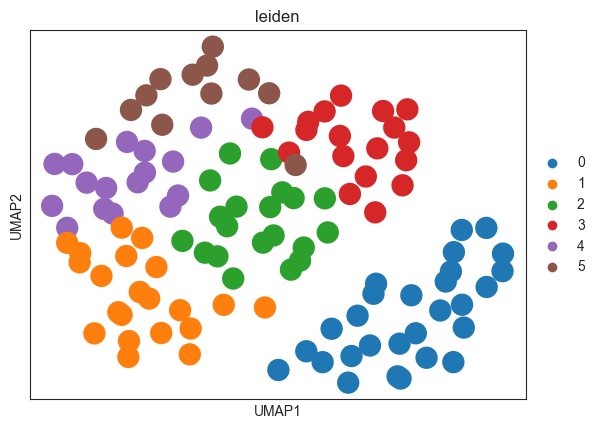

In [37]:
sc.pp.pca(adata_drug_reponse)
sc.pp.neighbors(adata_drug_reponse)
sc.tl.umap(adata_drug_reponse)
sc.tl.leiden(adata_drug_reponse, resolution = 1.5, key_added="leiden")
sc.pl.umap(adata_drug_reponse, color="leiden")

To visualize the clustering, cell lines are embedded into a UMAP embedding. The cell lines in the McFarland dataset are clustered into 7 groups in terms of gene–drug associations.

In [38]:
# Sort coefficients of the overlapping genes in decreasing order
coeff = pd.DataFrame({'coefficients': lr.coef_}, index=pdata.var_names).sort_values(by='coefficients', ascending=False)
coeff

,coefficients
CCND1,0.007015
IER3,0.006996
MIF,0.006977
ID1,0.005853
HMGA1,0.005712
...,...
CPA4,-0.004234
LAMB3,-0.004499
DDX1,-0.004648
GPRC5A,-0.004804


In [46]:
# Choose two sets of 3 cell lines randomly for visualisation
adata_drug_reponse.obs['cell_line_name'] = adata_drug_reponse.obs.index
cell_line_subset = adata_drug_reponse.obs.groupby('leiden').apply(lambda x: x.sample(3, random_state = 0)).reset_index(drop=True)
cell_line_subset = cell_line_subset[cell_line_subset.leiden.isin(['1','3'])].reset_index(drop=True)
cell_line_subset

/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_47969/726367742.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_line_subset = adata_drug_reponse.obs.groupby('leiden').apply(lambda x: x.sample(3, random_state = 0)).reset_index(drop=True)


,leiden,cell_line_name
0,1,LN-229
1,1,NCI-H2444
2,1,SW948
3,3,769-P
4,3,G-401
5,3,HCC1143


/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/yuge.ji/miniconda3/envs/pertpy_local/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The

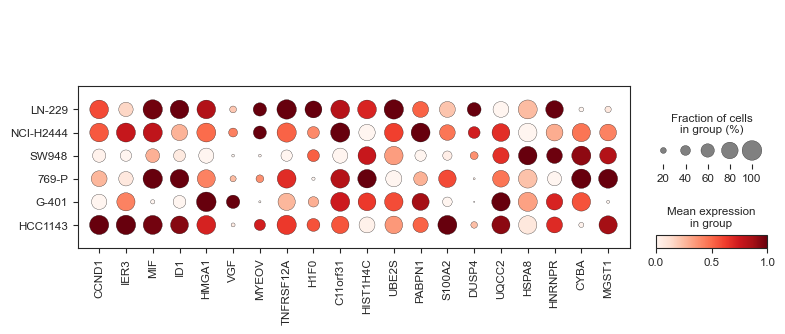

In [57]:
adata_subset = adata[adata.obs.perturbation != 'control']
sc.pl.dotplot(adata_subset[adata_subset.obs.cell_line_name.isin(cell_line_subset.cell_line_name.values)],
              var_names = coeff.index.values[0:20], 
              groupby = 'cell_line_name', standard_scale='var',
              categories_order=cell_line_subset.cell_line_name)

We observe that the gene expression pattern is similar within each cell line set but vary across two sets. This implies that genes with high absolute coefficient values have a greater impact on drug response. TODO: this isn't really true... have to think on this one